# Прогноз оттока клиентов

Задача: научиться прогнозировать отток клиентов для оператора связи. 
Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия.

Основная метрика для проверки качества модели: roc_auc

Дополнительная метрика: accuracy

**ОПИСАНИЕ УСЛУГ**

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**ОПИСАНИЕ ДАННЫХ**

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

* BeginDate – дата начала пользования услугами

* EndDate – дата окончания пользования услугами

* Type – тип оплаты: ежемесячный, годовой и тд

* PaperlessBilling – безналичный расчет

* PaymentMethod – способ оплаты

* MonthlyCharges – ежемесячные траты на услуги

* TotalCharges – всего потрачено денег на услуги

* Dependents – наличие иждивенцев

* Senior Citizen – наличие пенсионного статуса по возрасту

* Partner – наличие супруга(и)

* MultipleLines – наличие возможности ведения параллельных линий во время звонка

## Предобработка  и анализ данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
import plotly.express as px
import math
import seaborn as sns
from scipy import stats as st
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from sklearn.tree import DecisionTreeRegressor
import warnings

warnings.filterwarnings('ignore')

**Загружаем и обрабатываем данные**

In [2]:
contract = pd.read_csv('/datasets/final_provider/contract.csv', index_col='customerID')
personal = pd.read_csv('/datasets/final_provider/personal.csv', index_col='customerID')
internet = pd.read_csv('/datasets/final_provider/internet.csv', index_col='customerID')
phone = pd.read_csv('/datasets/final_provider/phone.csv', index_col='customerID')

**Изучаем информацию о договорах**
1. Просматриваем данные

In [3]:
contract.head(10)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05


2. Просматриваем информацию о данных

In [4]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB


**BeginDate** - дата начала пользования услугами

**EndDate** - дата окончания пользования услугами

**Type** - тип оплаты

**PaperlessBilling** - безналичный расчёт

**PaymentMethod** - способ оплаты

**MonthlyCharges** - ежемесячные траты

**TotalCharges** - общие траты

Сразу замечаем, что необходимо исправить типы данных в ряде столбцов: 
BeginDate, EndDate,TotalCharges

**Исправление типов данных в таблице CONTRACT**

In [5]:
contract['BeginDate']=contract['BeginDate'].astype('datetime64')

In [6]:
contract['EndDate'].unique()

array(['No', '2019-12-01 00:00:00', '2019-11-01 00:00:00',
       '2019-10-01 00:00:00', '2020-01-01 00:00:00'], dtype=object)

В дате отключения есть значение No, которое заменяем на дату актуальности договоров

In [7]:
end_date = '2020-02-01'
contract.loc[contract['EndDate'] == 'No', 'EndDate'] = end_date
contract['EndDate'] = contract['EndDate'].astype('datetime64')

В общих тратах тип переводим в численный, заменяя на отсутствующие значения те данные, которые нетипичны. 

In [8]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'],errors='coerce')
contract['TotalCharges']=contract['TotalCharges'].astype('float64')

Просматриваем данные по безналичному расчёту

In [9]:
contract['PaperlessBilling'].unique()

array(['Yes', 'No'], dtype=object)

В данных по безналичному рассчёту переводим тип в целочисленный

In [10]:
contract['PaperlessBilling'] = (contract['PaperlessBilling'] == 'Yes').astype('int8')
contract['PaperlessBilling'].unique()

array([1, 0], dtype=int8)

Просматриваем данные по способу оплаты

In [11]:
contract['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

Трансформируем данные по способу оплаты в целочисленный тип

In [12]:
def transform_payment_method(pmethod):
    if pmethod == 'Electronic check' :
        res = 0
    elif pmethod == 'Mailed check' :
        res = 1
    elif pmethod == 'Bank transfer (automatic)' :
        res = 2
    elif pmethod == 'Credit card (automatic)' :
        res = 3
    return res
contract['PaymentMethod'] = contract['PaymentMethod'].apply(transform_payment_method).astype('int8')

Просматриваем данные по типу оплаты

In [13]:
contract['Type'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

Трансформируем данные по типу оплаты в целочисленный тип

In [14]:
def transform_type(ptype):
    if ptype == 'Month-to-month' :
        res = 0
    elif ptype == 'One year' :
        res = 1
    elif ptype == 'Two year' :
        res = 2
    return res
contract['Type'] = contract['Type'].apply(transform_type).astype('int8')

Снова просматриваем информацию о данных

In [15]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   int8          
 3   PaperlessBilling  7043 non-null   int8          
 4   PaymentMethod     7043 non-null   int8          
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int8(3)
memory usage: 295.8+ KB


Данные успешно преобразованы в необходимые типы

**Добавление и ликвидация столбцов в таблице CONTRACT**

Создаём столбец с количеством дней пользования

In [17]:
contract['begin_days'] = (pd.Timestamp(end_date) - contract['BeginDate'])// np.timedelta64(1, 'D')
contract.drop('BeginDate', axis=1, inplace=True)
contract

,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,begin_days
customerID,,,,,,,
7590-VHVEG,2020-02-01,0,1,0,29.85,29.85,31
5575-GNVDE,2020-02-01,1,0,1,56.95,1889.50,1036
3668-QPYBK,2019-12-01,0,1,1,53.85,108.15,123
7795-CFOCW,2020-02-01,1,0,2,42.30,1840.75,1371
9237-HQITU,2019-11-01,0,1,0,70.70,151.65,153
...,...,...,...,...,...,...,...
6840-RESVB,2020-02-01,1,1,1,84.80,1990.50,730
2234-XADUH,2020-02-01,1,1,3,103.20,7362.90,2191
4801-JZAZL,2020-02-01,0,1,0,29.60,346.45,337


Создаём столбец с количеством дней, которое клиент уже не пользуется услугами данного оператора связи. Если клиент не уходил, значение будет равно нулю.

In [18]:
contract['end_days'] = (pd.Timestamp(end_date) - contract['EndDate']) // np.timedelta64(1, 'D')
contract.drop('EndDate', axis=1, inplace=True)

Создаём отдельный столбец, идентифицирующий уход клиента

In [19]:
contract['churn'] = (contract['end_days']>0).astype('int8')

Просматриваем обработанные данные

In [20]:
contract.head(10)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,begin_days,end_days,churn
customerID,,,,,,,,
7590-VHVEG,0,1,0,29.85,29.85,31,0,0
5575-GNVDE,1,0,1,56.95,1889.50,1036,0,0
3668-QPYBK,0,1,1,53.85,108.15,123,62,1
7795-CFOCW,1,0,2,42.30,1840.75,1371,0,0
9237-HQITU,0,1,0,70.70,151.65,153,92,1
9305-CDSKC,0,1,0,99.65,820.50,337,92,1
1452-KIOVK,0,1,3,89.10,1949.40,671,0,0
6713-OKOMC,0,0,1,29.75,301.90,306,0,0
7892-POOKP,0,1,0,104.80,3046.05,945,92,1


Данные в таблице CONTRACT успешно преобразованы и обработаны

**Изучаем информацию о персональных данных**

1. Просматриваем данные

In [21]:
personal.head(20)

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No
9305-CDSKC,Female,0,No,No
1452-KIOVK,Male,0,No,Yes
6713-OKOMC,Female,0,No,No
7892-POOKP,Female,0,Yes,No


2. Просматриваем информацию о данных

In [22]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


In [23]:
personal.isnull().sum()

gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

In [24]:
personal['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [25]:
personal['SeniorCitizen'].unique()

array([0, 1])

In [26]:
personal['Partner'].unique()

array(['Yes', 'No'], dtype=object)

In [27]:
personal['Dependents'].unique()

array(['No', 'Yes'], dtype=object)

**gender** - пол пользователя

**SeniorCitizen** - наличие пенсионного статуса

**Partner** - наличие супруга/супруги

**Dependents** - наличие иждивенцев

In [28]:
personal['if_male'] = (personal['gender'] == 'Male').astype('int8')
personal.drop('gender', axis=1, inplace=True)
personal['Partner'] = (personal['Partner'] == 'Yes').astype('int8')
personal['Dependents'] = (personal['Dependents'] == 'Yes').astype('int8')
personal.head(10)

,SeniorCitizen,Partner,Dependents,if_male
customerID,,,,
7590-VHVEG,0,1,0,0
5575-GNVDE,0,0,0,1
3668-QPYBK,0,0,0,1
7795-CFOCW,0,0,0,1
9237-HQITU,0,0,0,0
9305-CDSKC,0,0,0,0
1452-KIOVK,0,0,1,1
6713-OKOMC,0,0,0,0
7892-POOKP,0,1,0,0


**Изучаем информацию об интернет-услугах**

1. Просматриваем данные

In [29]:
internet.head(10)

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No
9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
6713-OKOMC,DSL,Yes,No,No,No,No,No
7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes


2. Просматриваем информацию о данных

In [30]:
internet.info(10)

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


**InternetService** - тип подключения

**OnlineSecurity** - наличие блокировки небезопасных сайтов

**OnlineBackup** - наличие облачного хранилища файлов для резервного копирования данных

**DeviceProtection** - наличие антивируса

**TechSupport** - наличие выделенной линии технической поддержки

**StreamingTV** - наличие стримингового телевидения

**StreamingMovies** - наличие каталога фильмов

Проверяем значения

In [31]:
print(internet['InternetService'].unique())
print(internet['OnlineSecurity'].unique())
print(internet['OnlineBackup'].unique())
print(internet['DeviceProtection'].unique())
print(internet['TechSupport'].unique())
print(internet['StreamingTV'].unique())
print(internet['StreamingMovies'].unique())

['DSL' 'Fiber optic']
['No' 'Yes']
['Yes' 'No']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']


Проверяем наличие отсутствующих значений

In [32]:
internet.isnull().sum()

InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

In [33]:
internet['fiber_optic'] = (internet['InternetService'] == 'Fiber optic').astype('int8')
internet.drop('InternetService', axis=1, inplace=True)

In [34]:
for col in ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
    internet[col] = (internet[col] == 'Yes').astype('int8')

In [35]:
internet.head(10)

,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,fiber_optic
customerID,,,,,,,
7590-VHVEG,0,1,0,0,0,0,0
5575-GNVDE,1,0,1,0,0,0,0
3668-QPYBK,1,1,0,0,0,0,0
7795-CFOCW,1,0,1,1,0,0,0
9237-HQITU,0,0,0,0,0,0,1
9305-CDSKC,0,0,1,0,1,1,1
1452-KIOVK,0,1,0,0,1,0,1
6713-OKOMC,1,0,0,0,0,0,0
7892-POOKP,0,0,1,1,1,1,1


**Изучаем информацию об услугах телефонии**

1. Просматриваем данные

In [36]:
phone.head()

,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


2. Просматриваем информацию о данных

In [37]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


**MultipleLines** - наличие возможности ведения параллельных линий во время звонка

Просматриваем возможные варианты

In [38]:
phone['MultipleLines'].unique()

array(['No', 'Yes'], dtype=object)

In [39]:
phone['MultipleLines'] = (phone['MultipleLines'] == 'Yes').astype('int8')

**ОБЪЕДИНЯЕМ ТАБЛИЦЫ В ОДНУ**

In [40]:
data = contract.join(personal, how='left').join(internet, how='left').join(phone, how='left').fillna(0)

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   int8   
 1   PaperlessBilling  7043 non-null   int8   
 2   PaymentMethod     7043 non-null   int8   
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   begin_days        7043 non-null   int64  
 6   end_days          7043 non-null   int64  
 7   churn             7043 non-null   int8   
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   int8   
 10  Dependents        7043 non-null   int8   
 11  if_male           7043 non-null   int8   
 12  OnlineSecurity    7043 non-null   float64
 13  OnlineBackup      7043 non-null   float64
 14  DeviceProtection  7043 non-null   float64
 15  TechSupport       7043 non-null   float64
 16  StreamingTV       7043 non-null 

In [42]:
data.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,begin_days,end_days,churn,SeniorCitizen,Partner,Dependents,if_male,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,fiber_optic,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,1,0,29.85,29.85,31,0,0,0,1,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5575-GNVDE,1,0,1,56.95,1889.50,1036,0,0,0,0,0,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3668-QPYBK,0,1,1,53.85,108.15,123,62,1,0,0,0,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7795-CFOCW,1,0,2,42.30,1840.75,1371,0,0,0,0,0,1,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
9237-HQITU,0,1,0,70.70,151.65,153,92,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [43]:
data.isnull().sum()

Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
begin_days          0
end_days            0
churn               0
SeniorCitizen       0
Partner             0
Dependents          0
if_male             0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
fiber_optic         0
MultipleLines       0
dtype: int64

Проверяем наличие дубликатов

In [44]:
data.duplicated().sum()

13

Удаляем дубликаты, так как их количество сравнительно мало, и их удаление не повлияет на дальнейшую работу и построение моделей

In [45]:
data.drop_duplicates(inplace=True)

In [46]:
data.duplicated().sum()

0

Добавим признак lifetime -  кол-во дней пользования сервисами

In [47]:
data['lifetime'] = data['begin_days'] - data['end_days']

In [48]:
data.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,begin_days,end_days,churn,SeniorCitizen,Partner,...,if_male,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,fiber_optic,MultipleLines,lifetime
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,1,0,29.85,29.85,31,0,0,0,1,...,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,31
5575-GNVDE,1,0,1,56.95,1889.50,1036,0,0,0,0,...,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1036
3668-QPYBK,0,1,1,53.85,108.15,123,62,1,0,0,...,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,61
7795-CFOCW,1,0,2,42.30,1840.75,1371,0,0,0,0,...,1,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1371
9237-HQITU,0,1,0,70.70,151.65,153,92,1,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,61


**ВЫВОД**

Предобработка данных произведена успешно

Строковые типы преобразованны в числовые категории

Дубликаты удалены

Отсутствующих значений нет

Построим графики для выявления определяющих факторов

Среди ушедших клиентов самый большой процент среди тех, кто оплачивал услуги ежемесячно

<AxesSubplot:xlabel='Type', ylabel='count'>

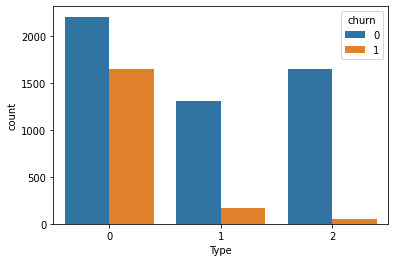

In [49]:
sns.countplot(x='Type', hue='churn', data=data)

Среди ушедших клиентов большой процент пользовался безналичным расчётом.
В принципе, признаки Paperless Billing и Payment Method несут в себе одинаковую информацию.

<AxesSubplot:xlabel='PaperlessBilling', ylabel='count'>

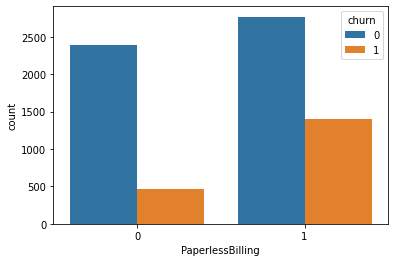

In [50]:
sns.countplot(x='PaperlessBilling', hue='churn', data=data)

<AxesSubplot:xlabel='PaymentMethod', ylabel='count'>

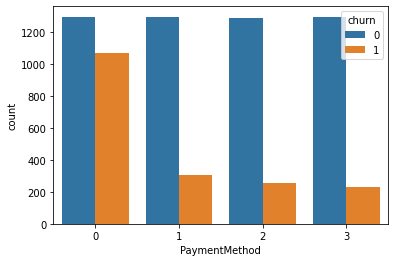

In [51]:
sns.countplot(x='PaymentMethod', hue='churn', data=data)

Среди ушедших в процентном соотношении много пенсионеров, но относительно общего числа пользователей их сравнительно мало

<AxesSubplot:xlabel='SeniorCitizen', ylabel='count'>

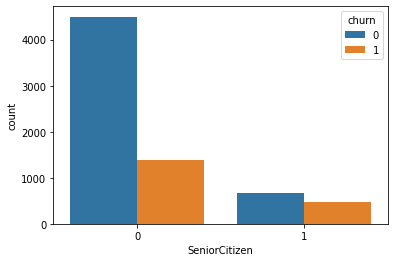

In [52]:
sns.countplot(x='SeniorCitizen', hue='churn', data=data)

Среди ушедших клиентов примерно 50% не состояли в браке

<AxesSubplot:xlabel='Partner', ylabel='count'>

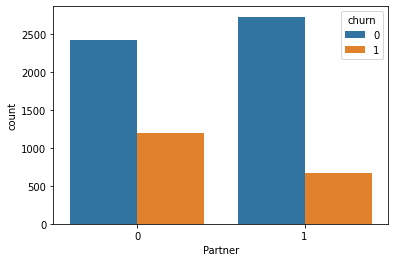

In [53]:
sns.countplot(x='Partner', hue='churn', data=data)

Пол также почти не влияет на прекращение пользования услугами

<AxesSubplot:xlabel='if_male', ylabel='count'>

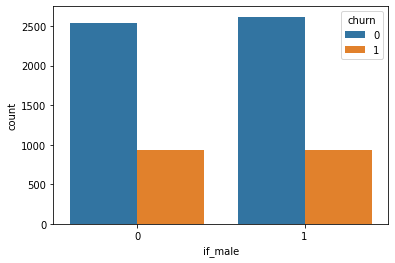

In [54]:
sns.countplot(x='if_male', hue='churn', data=data)

Наличие иждивенцев также почти не влияет на прекращение пользования услугами

<AxesSubplot:xlabel='Dependents', ylabel='count'>

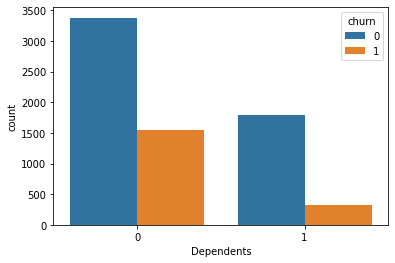

In [55]:
sns.countplot(x='Dependents', hue='churn', data=data)

Многие ушедшие клиенты пользовались оптоволокном

<AxesSubplot:xlabel='fiber_optic', ylabel='count'>

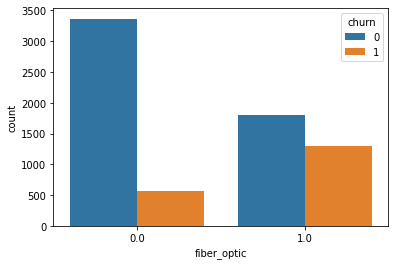

In [56]:
sns.countplot(x='fiber_optic', hue='churn', data=data)

Ушедшие клиенты платили в месяц больше

<AxesSubplot:xlabel='MonthlyCharges', ylabel='churn'>

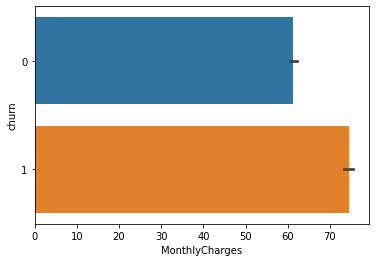

In [57]:
sns.barplot(x='MonthlyCharges', y = 'churn', data=data, orient='h')

Ушедшие клиенты сравнительно меньше по времени пользовались услугами, чем те, которые остались


<AxesSubplot:xlabel='lifetime', ylabel='churn'>

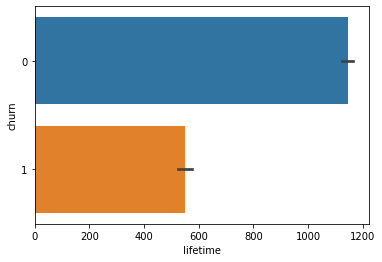

In [58]:
sns.barplot(x='lifetime', y = 'churn', data=data, orient='h')

Строим матрицу корреляции

Факторы, имеющие корреляцию больше 0,8 удалены, а необходимая информация из них сгруппирована в признаке lifetime

In [59]:
cor_columns = ['churn', 'MonthlyCharges', 'TotalCharges','begin_days', 'end_days']
correlation = data[cor_columns].corr()
correlation

,churn,MonthlyCharges,TotalCharges,begin_days,end_days
churn,1.000000,0.192862,-0.198829,-0.312731,0.889368
MonthlyCharges,0.192862,1.000000,0.650619,0.258717,0.180711
TotalCharges,-0.198829,0.650619,1.000000,0.829083,-0.174008
begin_days,-0.312731,0.258717,0.829083,1.000000,-0.264211
end_days,0.889368,0.180711,-0.174008,-0.264211,1.000000


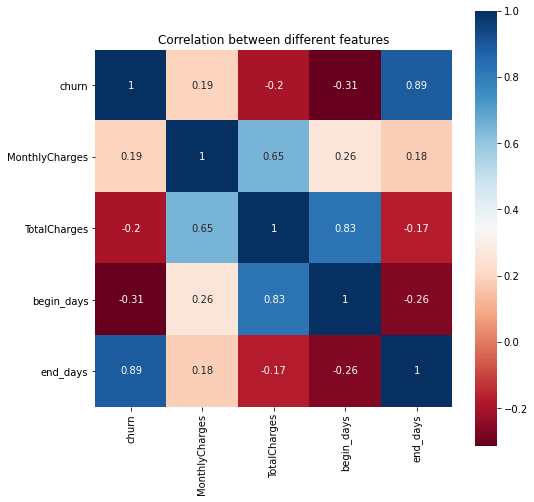

In [60]:
cor_columns = ['churn', 'MonthlyCharges', 'TotalCharges','begin_days', 'end_days']
correlation = data[cor_columns].corr()
plt.figure(figsize=(8, 8))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='RdBu')

plt.title('Correlation between different features')
plt.show()

Так как мы создали признак количества дней пользования, признаки end_days и begin_days можно удалить. Также удалим признак, определяющий пол.

In [61]:
data.drop(['begin_days', 'end_days', 'if_male'], axis=1, inplace=True)

Просмотрим количество ушедших клинетов относительно общего числа.

In [62]:
gone = data[data['churn']== 1]
gone.count()

Type                1866
PaperlessBilling    1866
PaymentMethod       1866
MonthlyCharges      1866
TotalCharges        1866
churn               1866
SeniorCitizen       1866
Partner             1866
Dependents          1866
OnlineSecurity      1866
OnlineBackup        1866
DeviceProtection    1866
TechSupport         1866
StreamingTV         1866
StreamingMovies     1866
fiber_optic         1866
MultipleLines       1866
lifetime            1866
dtype: int64

Процент ушедших клиентов по предоставленным данным около 26-27%
Соотношение примерно 1:3

**Вывод**
1. Данные успешно загружены
2. Данные изучены
3. Данные предобработаны
4. Объективно не несущие пользу признаки удалены
5. Добавлены необходимые для дальнейшей работы признаки
6. Данные проанализированы
7. Построены наглядные графики
8. Выявлено соотношение ушедших клиентов к оставшимся клиентам
9. Данные подготовлены для дальнейшей работы и обучения моделей

## Обучение модели

Выделяем признаки

In [63]:
target = data['churn']
features = data.drop('churn', axis=1)

Делим на выборки

In [64]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=123)

In [65]:
print(f"Размер тренировочной выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер тренировочной выборки: (5624, 17)
Размер тестовой выборки: (1406, 17)


Пробуем модели

**1. Логистическая регрессия**

In [66]:
model_lr = LogisticRegression()
roc_auc_lr_v = cross_val_score(model_lr, X_train, y_train, cv=5, scoring='roc_auc').mean()
print(f"AUC_ROC для модели Логистической Регрессии на кросс-валидации: {roc_auc_lr_v:.3f}")
accuracy_lr = cross_val_score(model_lr, X_train, y_train, cv=5, scoring='accuracy').mean()
print(f"ACCURACY для модели Логистической Регрессии: {accuracy_lr:.3f}")

AUC_ROC для модели Логистической Регрессии на кросс-валидации: 0.838
ACCURACY для модели Логистической Регрессии: 0.797


In [67]:
model_lr.fit(X_train, y_train)

LogisticRegression()

In [68]:
pred_lr = model_lr.predict_proba(X_test)[:, 1]
roc_auc_lr_t = roc_auc_score(y_test, pred_lr)
print(f"AUC_ROC для модели Логистической Регрессии на тестовой выборке: {roc_auc_lr_t:.3f}")

AUC_ROC для модели Логистической Регрессии на тестовой выборке: 0.846


In [69]:
accuracy_lr_t = accuracy_score(y_test, model_lr.predict(X_test))
print(f"ACCURACY для модели Логистической Регрессии на тестовой выборке: {accuracy_lr_t:.3f}")

ACCURACY для модели Логистической Регрессии на тестовой выборке: 0.803


Выявим наиболее влияющие на предсказание признаки

In [70]:
importances_lr = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model_lr.coef_[0]
})
importances_lr = importances_lr.sort_values(by='Importance', ascending=False)
importances_lr

,Attribute,Importance
14,fiber_optic,0.487209
1,PaperlessBilling,0.378311
12,StreamingTV,0.292782
13,StreamingMovies,0.244853
15,MultipleLines,0.185694
5,SeniorCitizen,0.156614
3,MonthlyCharges,0.006753
4,TotalCharges,0.000284
16,lifetime,-0.001852
6,Partner,-0.013829


Text(0.5, 1.0, 'Feature importance')

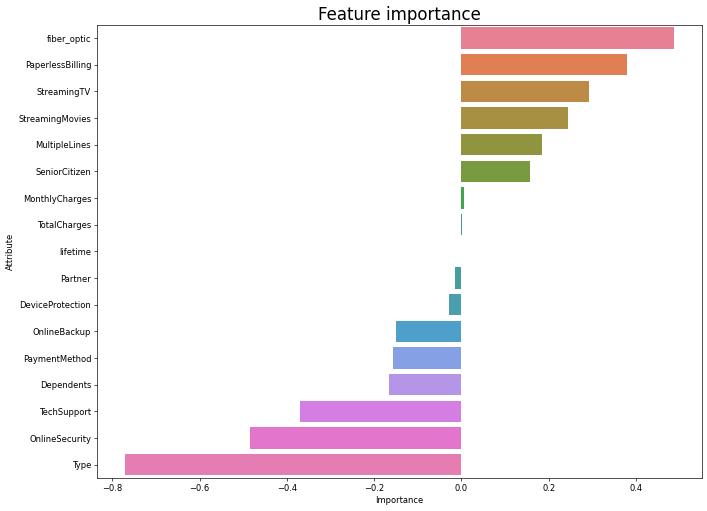

In [71]:
plt.figure(figsize=(13,10), dpi= 60)
ax = sns.barplot(x = 'Importance', y = 'Attribute', data = importances_lr ,palette = 'husl')
plt.title('Feature importance', fontsize = 20)

**2. Случайный лес**

In [72]:
model_RF = RandomForestClassifier(n_estimators=120, max_depth = 10,max_features = 9, random_state=12345 )
roc_auc_RF = cross_val_score(model_RF, X_train, y_train, cv=5, scoring='roc_auc').mean()
print(f"AUC_ROC для модели Случайного Леса на кросс-валидации: {roc_auc_RF:.3f}")
accuracy_RF = cross_val_score(model_RF, X_train, y_train, cv=5, scoring='accuracy').mean()
print(f"ACCURACY для модели Случайного Леса: {accuracy_RF:.3f}")

AUC_ROC для модели Случайного Леса на кросс-валидации: 0.863
ACCURACY для модели Случайного Леса: 0.824


In [73]:
model_RF.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features=9, n_estimators=120,
                       random_state=12345)

In [74]:
pred_rf = model_RF.predict_proba(X_test)[:, 1]
roc_auc_rf_t = roc_auc_score(y_test, pred_rf)
print(f"AUC_ROC для модели Случайного Леса на тестовой выборке: {roc_auc_rf_t:.3f}")

AUC_ROC для модели Случайного Леса на тестовой выборке: 0.867


In [75]:
accuracy_rf_t = accuracy_score(y_test, model_RF.predict(X_test))
print(f"ACCURACY для модели Случайного Леса на тестовой выборке: {accuracy_rf_t:.3f}")

ACCURACY для модели Случайного Леса на тестовой выборке: 0.818


Выявим наиболее влияющие на предсказание признаки

In [76]:
importances_RF = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model_RF.feature_importances_
})
importances_RF = importances_RF.sort_values(by='Importance', ascending=False)
importances_RF

,Attribute,Importance
16,lifetime,0.289574
0,Type,0.167348
3,MonthlyCharges,0.146948
4,TotalCharges,0.146488
14,fiber_optic,0.079339
2,PaymentMethod,0.042480
1,PaperlessBilling,0.017143
8,OnlineSecurity,0.015575
15,MultipleLines,0.013041
11,TechSupport,0.012268


Text(0.5, 1.0, 'Feature importance')

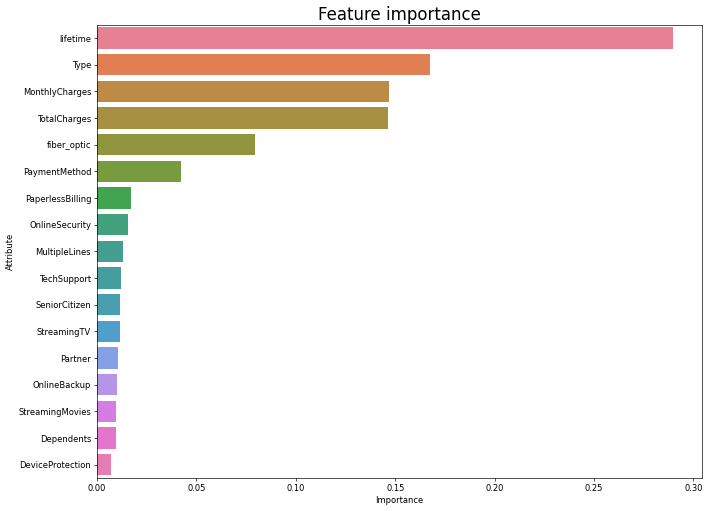

In [77]:
plt.figure(figsize=(13,10), dpi= 60)
ax = sns.barplot(x = 'Importance', y = 'Attribute', data = importances_RF ,palette = 'husl')
plt.title('Feature importance', fontsize = 20)

**3. Дерево решений**

In [78]:
model_DT = DecisionTreeClassifier(random_state=12345, max_depth=6)
roc_auc_DT = cross_val_score(model_DT, X_train, y_train, cv=5, scoring='roc_auc').mean()
print(f"AUC_ROC для модели Дерева Решений на кросс-валидации: {roc_auc_DT:.3f}")
accuracy_DT = cross_val_score(model_DT, X_train, y_train, cv=5, scoring='accuracy').mean()
print(f"ACCURACY для модели Дерева Решений: {accuracy_DT:.3f}")

AUC_ROC для модели Дерева Решений на кросс-валидации: 0.841
ACCURACY для модели Дерева Решений: 0.803


In [79]:
model_DT.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, random_state=12345)

In [80]:
pred_DT = model_DT.predict_proba(X_test)[:, 1]
roc_auc_DT_t = roc_auc_score(y_test, pred_DT)
print(f"AUC_ROC для модели Дерева Решений на тестовой выборке: {roc_auc_DT_t:.3f}")

AUC_ROC для модели Дерева Решений на тестовой выборке: 0.853


In [81]:
accuracy_DT_t = accuracy_score(y_test, model_DT.predict(X_test))
print(f"ACCURACY для модели Дерева Решений на тестовой выборке: {accuracy_DT_t:.3f}")

ACCURACY для модели Дерева Решений на тестовой выборке: 0.819


In [82]:
importances_DT = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model_DT.feature_importances_
})
importances_DT = importances_DT.sort_values(by='Importance', ascending=False)
importances_DT

,Attribute,Importance
0,Type,0.431252
16,lifetime,0.310476
14,fiber_optic,0.137182
4,TotalCharges,0.043605
3,MonthlyCharges,0.039699
2,PaymentMethod,0.022921
15,MultipleLines,0.005619
11,TechSupport,0.004289
13,StreamingMovies,0.003187
7,Dependents,0.001162


Text(0.5, 1.0, 'Feature importance')

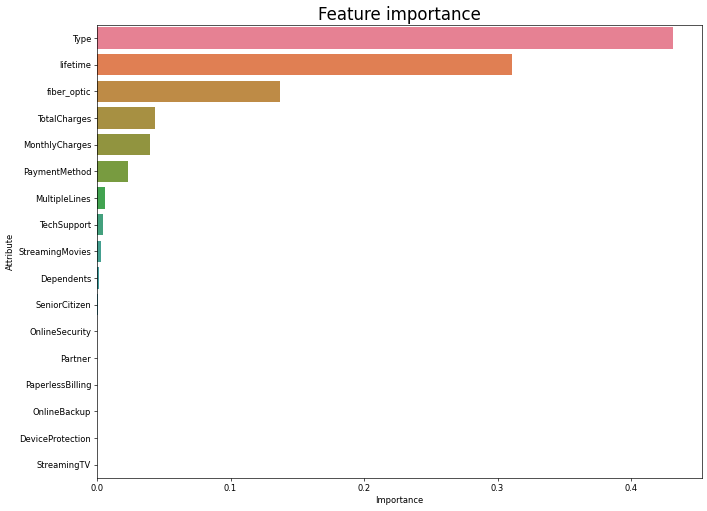

In [83]:
plt.figure(figsize=(13,10), dpi= 60)
ax = sns.barplot(x = 'Importance', y = 'Attribute', data = importances_DT ,palette = 'husl')
plt.title('Feature importance', fontsize = 20)

**Вывод**

Наилучший результат по метрике auc_roc на тестовой выборке показала модель случайного леса: 0.867, что удовлетворяет условию задания.
Второй по качеству оказалась модель дерева решений (0.853), что также удовлетворяет условию.  Наихудшей оказалась модель логистической регрессии(0.846).

## Общий вывод

1. Данные были загружены и обработаны
2. В результате анализа данных были сделаны следующие выводы:
   1. Пол клиентов, наличие супруга/супруги и иждивенцев практически не влияют на их уход
   2. Большой процент ушедших клиентов пользовался оптоволокном, оплачивал услуги ежемесячно и использовал безналичный расчёт
   3. Ушедшие пользователи платили больше в месяц: возможно, они переплачивали за ненужные услуги или подбирали не оптимальные тарифы
   
3. Было выявлено, что ушедших пользователей около 26%, что составляет примерно 1/4 от общего количества. Соответственно, дальнейшее разделение на выборки зависит от этих данных
4. Были испробованы 3 модели, показавшие удовлетворяющий результат на тестовой выборке


На мой взгляд, подводя итог анализа, можно предположить, что пользователи в своём большинстве остаются недовольны своим выбором в первые месяцы пользования. Либо им в общем и целом не подходят любые вариации предложений, либо они не знают всех возможных опций и выгодных условий.
Стоит сосредоточиться на новопришедших клиентах.